In [1]:
from contextlib import suppress

import numpy as np
import pandas as pd

# For pretty writing
from IPython.display import display, Markdown
from sklearn.cluster import KMeans

# Analyse exploratoire de données (Exploratory Data Analysis)


## Partie 0 - Outils

In [2]:
from pathlib import Path

from requests import get, Response
from hashlib import sha256
from tqdm.notebook import tqdm
from zipfile import ZipFile
from IPython.display import display, Markdown
import pandas as pd

_cache_folder = Path('~/.cache/gn_p7').expanduser()
_cache_folder.mkdir(parents=True, exist_ok=True)

_ds_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip'


def download(url: str) -> Path:
    url_id: str = sha256(url.encode('utf-8')).hexdigest()
    local_path: Path = _cache_folder / url_id
    local_path.parent.mkdir(parents=True, exist_ok=True)
    if not local_path.exists():
        tmp_path: Path = _cache_folder / (url_id + '.tmp')
        res: Response = get(url, stream=True)
        with tmp_path.open('wb') as f, tqdm(
                total=int(res.headers.get('content-length')),
                desc=f'Downloading {url}',
                unit_scale=True) as q:
            for chunk in res.iter_content(chunk_size=8192):
                q.update(len(chunk))
                f.write(chunk)
        tmp_path.replace(local_path)
    return local_path


def download_zip_archive(url: str) -> Path:
    """Download a zip archive, extract it then return the folder containing its content"""
    archive_path: Path = download(url)
    archive_folder: Path = Path(archive_path.as_posix() + '.dir')

    if not archive_folder.exists():
        print(f'Extracting archive {url}...', flush=True)
        archive_temp: Path = Path(archive_path.as_posix() + '.tmp')
        archive_temp.mkdir(parents=True, exist_ok=True)
        archive: ZipFile = ZipFile(archive_path)
        archive.extractall(path=archive_temp)
        archive_temp.replace(archive_folder)
        print(f'Extracting archive {url}...done', flush=True)

    return archive_folder


def get_dataset(name: str) -> pd.DataFrame:
    folder = download_zip_archive(_ds_url)
    if not name.endswith('.csv'):
        name = f'{name}.csv'
    try:
        return pd.read_csv(folder / name)
    except FileNotFoundError:
        display(Markdown(f'# ERROR: Dataset {name!r} not found, available datasets are:\n' + '\n'.join(
            f'- {p.name}' for p in sorted(folder.iterdir(), key=(lambda x: x.name.lower())))))
        raise KeyError(name) from None


In [3]:
# Scoring related
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    matrix = confusion_matrix(y_truth, y_prediction, labels=classes)
    sns.heatmap(matrix / len(y_truth), annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name!r}', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }

## Partie 1 - Applications
Notre dataset contiens plusieurs fichiers.
Nous feront comme le notebook exemple, en commençant initialement avec application_{train,test}, puis en rajoutant des données pour améliorer la performance du modèle.

### Partie 1.1 - Données brutes

Il serai peut-être nécéssaire de prétraiter les données, cependant je vais tenter de créer un modèle initial sur les données brutes pour servir de référence

### 1.1.1 - k-Means

k-Means est linéaire, et non supervisé, il aura probablement un score assez faible

# WARNING: k-Means distinguish between two classes, but might switch classes

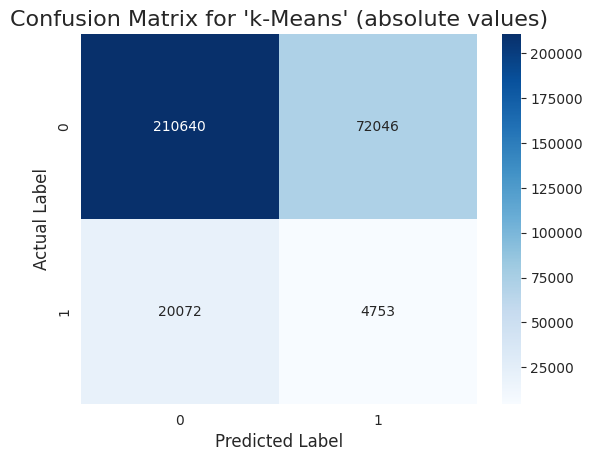

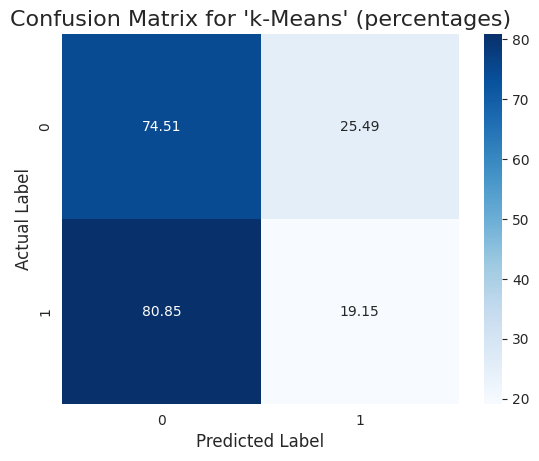

{'accuracy': 0.7004399842607256,
 'precision': 0.061888826677430696,
 'recall': 0.19146022155085599,
 'f1_score': 0.09354089585137369}

In [4]:
# Scoring related
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def heat_map(matrix: np.ndarray, classes: list[str], title: str, y_label: str, x_label: str, fmt: str) -> None:
    sns.heatmap(matrix, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.show()


def confusion(
        y_truth: pd.Series,
        y_prediction: pd.Series,
        model_name: str,
) -> dict:
    assert len(y_truth) == len(y_prediction), "Input Series must have the same length."
    classes = sorted(set(y_truth) | set(y_prediction))
    heat_map(
        (matrix := confusion_matrix(y_truth, y_prediction, labels=classes)),
        classes, f'Confusion Matrix for {model_name!r} (absolute values)', 'Actual Label', 'Predicted Label', 'd')

    # 'matrix' est la matrice de confusion non normalisée
    # On divise chaque valeur par la somme de sa ligne
    # np.newaxis est crucial pour que la division se fasse correctement
    heat_map(
        (100 * (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])),
        classes, f'Confusion Matrix for {model_name!r} (percentages)', 'Actual Label', 'Predicted Label', '.02f')

    return {
        # TODO: More metrics
        'accuracy': accuracy_score(y_truth, y_prediction),
        'precision': precision_score(y_truth, y_prediction, zero_division=0),
        'recall': recall_score(y_truth, y_prediction, zero_division=0),
        'f1_score': f1_score(y_truth, y_prediction, zero_division=0)
    }


def k_means():
    display(Markdown('# WARNING: k-Means distinguish between two classes, but might switch classes'))
    X = get_dataset('application_train.csv')
    y_true = X.pop('TARGET')
    for column in list(X.columns):
        try:
            X[column] = X[column].astype(float).fillna(0)
        except ValueError:
            X.pop(column)
    model = KMeans(len(y_true.unique()))
    y_pred = model.fit(X).predict(X)
    return confusion(y_true, y_pred, 'k-Means')


k_means()

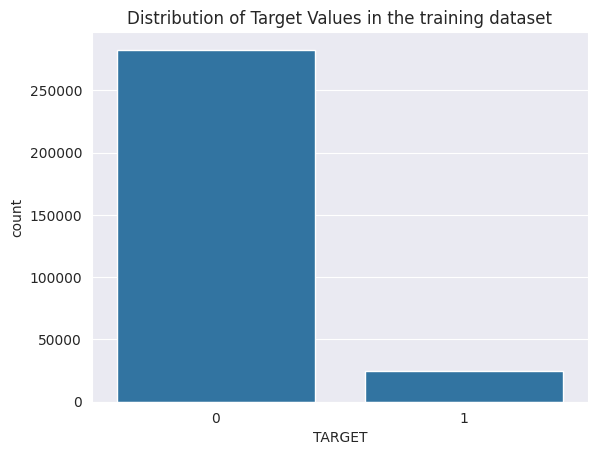

<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, seuls 8.07% des clients ont difficultés de paiement</b><br>

In [7]:
# Similar to plt.hist, but automatically labels the axes
plt.show(sns.countplot(data=(tmp:=get_dataset('application_train.csv')), x='TARGET').set_title(
    'Distribution of Target Values in the training dataset').figure)

display(Markdown(
    '<b>Nous pouvons voir ici un clair déséquilibre des classes, en effet, '
    f'seuls {100*sum(tmp.TARGET) / len(tmp.TARGET):.2f}% des clients ont difficultés de paiement</b><br>'
))

### 1.1.2 ...
